In [2]:
!pip install transformers
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00
2.0.1+cu118
4.33.1
2.7.12


In [3]:
#kogpt-trinity 토크나이저와 모델 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') #kogpt-trinity
model = AutoModelWithLMHead.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5")



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1479: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
import csv
# CSV 파일 line으로 바꾸기 위한 코드
with open('/content/drive/MyDrive/미래에셋/데이터모음/(증강)지싟아하노가다kobart.csv', mode='r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)

    # 특정 컬럼 인덱스 선택 (0부터 시작)
    target_column_index =1# 예: 2번째 컬럼을 선택하려면 2로 설정

    # 선택한 컬럼의 데이터를 저장할 리스트 생성
    column_data = []

    # 각 행에서 선택한 컬럼의 데이터 추출
    for row in csv_reader:
        if len(row) > target_column_index:
            column_data.append(row[target_column_index])


In [ ]:
# 텍스트 파일로 데이터 저장
with open('text_data.txt', 'w',encoding='utf-8') as txt_file:
    for item in column_data:
        txt_file.write("%s\n" % item)


In [ ]:
with open('text_data.txt',encoding='utf-8') as f:
    lines = f.read()
lines=" ".join(lines.split())
print(len(lines)) #총 line 개수

3527941


In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
class TransformersTokenizer(Transform): #토크나이징 함수
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks)) #텐서로 반환
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))



#split data
train=lines[:int(len(lines)*0.9)] #train과 valid 데이터 9:1로 분리
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len) #훈련 데이터 생성
# dls.show_batch(max_n=2)

SuggestedLRs(valley=6.30957365501672e-05)


epoch,train_loss,valid_loss,perplexity,time
0,2.229405,1.886742,6.597836,04:28
1,0.916530,1.042577,2.836517,04:28
2,0.425964,0.871937,2.391538,04:28
3,0.200666,0.826298,2.284845,04:29
4,0.119673,0.829289,2.291688,04:30


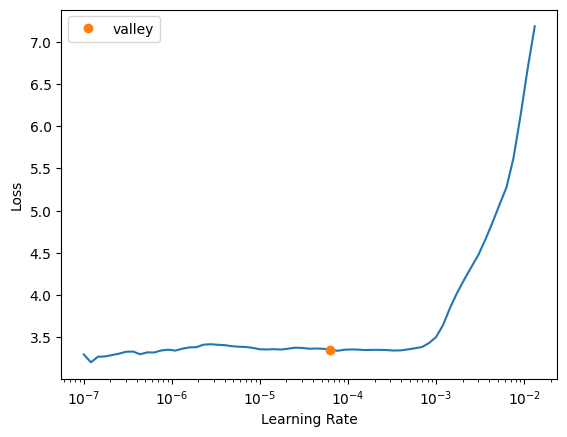

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]


learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(5, lr)
#learn.fine_tune(3)

In [ ]:
prompt='증거금이 있어야 청약이 가능합니다.'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=256,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,
                           use_cache=True
                          )
text=tokenizer.decode(preds[0].cpu().numpy())

In [ ]:
#니다 로 끝나는 말에 .찍어주기
pattern = r'(니다)([\s\n]+)'
replacement = r'\1.\2'
result = re.sub(pattern, replacement, text)

print(result)

증거금이 있어야 청약이 가능합니다. 만약 청약할 때 필요한 돈이 부족하면 계좌에 넣어두세요. 공모주 받은 주식은 상장일에 해당계좌로 입고됩니다. 타사대체출고 즉시 매매 할 수 있습니다. 단, 잔고, 권리등이 없는 주식을 받으셨다면 환불일날 됩니다. 바로 출고는 불가능 합니다. 매도 후 영업일이 지나야 그 금액으로 또 매수 / 매도를 하실수 없습니다. 균등배정이 경쟁률이 높으면 1주도 않을 수도 있습니다.그리고 비례 배정은 하나도 받지 못합니다. 주의하세요 다른증권사로 중복청약 불가하며 한곳에만 해야됩니다. 100주를 배정받으시려고 한다면 50주의 물량을 신청하시면 됩니.다만 이 경우는 돈을 많이 넣어야 몇 주를 더 받을지 결정될 것입니다. 주관 증권사에 따라 수수료가 지출되는 경우도 있고 되지 않는 수수료도 있기 때문에 많은 금액을 바랍니다. 것이 유리하다고 설명하기는 어렵습니다. 보통의 경우 공모가 대비하여 60~400%사이에서 시초가가 결정이 되는데요. 신규상장하는 기업의 경우에는 수요예측을 통하여공모가의 90퍼센트 에서 200 퍼센트범위에서 기준가로 결정을 하게 되고 높은 당일에는 호가폭이 넓어져서 거래량이 많아야 하며 미래에셋증권이 상대적으로 가격이 상승하였습니다. 비상장한 회사는 시장이라서 보호조치가 없습니다. 개인간의


In [ ]:
#prompt제거
text_without_keyword = result.replace(prompt, "")

print(text_without_keyword)

 만약 청약할 때 필요한 돈이 부족하면 계좌에 넣어두세요. 공모주 받은 주식은 상장일에 해당계좌로 입고됩니다. 타사대체출고 즉시 매매 할 수 있습니다. 단, 잔고, 권리등이 없는 주식을 받으셨다면 환불일날 됩니다. 바로 출고는 불가능 합니다. 매도 후 영업일이 지나야 그 금액으로 또 매수 / 매도를 하실수 없습니다. 균등배정이 경쟁률이 높으면 1주도 않을 수도 있습니다.그리고 비례 배정은 하나도 받지 못합니다. 주의하세요 다른증권사로 중복청약 불가하며 한곳에만 해야됩니다. 100주를 배정받으시려고 한다면 50주의 물량을 신청하시면 됩니.다만 이 경우는 돈을 많이 넣어야 몇 주를 더 받을지 결정될 것입니다. 주관 증권사에 따라 수수료가 지출되는 경우도 있고 되지 않는 수수료도 있기 때문에 많은 금액을 바랍니다. 것이 유리하다고 설명하기는 어렵습니다. 보통의 경우 공모가 대비하여 60~400%사이에서 시초가가 결정이 되는데요. 신규상장하는 기업의 경우에는 수요예측을 통하여공모가의 90퍼센트 에서 200 퍼센트범위에서 기준가로 결정을 하게 되고 높은 당일에는 호가폭이 넓어져서 거래량이 많아야 하며 미래에셋증권이 상대적으로 가격이 상승하였습니다. 비상장한 회사는 시장이라서 보호조치가 없습니다. 개인간의


In [ ]:
#모델 경로에 저장
learn.model.save_pretrained("/content/drive/MyDrive/gpt/이게최종")

In [4]:
#모델 불러오기
model=AutoModelWithLMHead.from_pretrained('/content/drive/MyDrive/gpt/이게최종')

In [ ]:
#불러온 모델로 test
prompt="공모주 청약하는법"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
model=model.cuda()
preds =model.generate(inp,
                           max_length=256,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,
                           use_cache=True
                          )
tokenizer.decode(preds[0].cpu().numpy())